In [1]:
# import everything you need
from src import *
import numpy as np
import matplotlib.pyplot as plt

# set plot properties
plt.rcParams.update({'font.size': 25,
                     'font.family': 'Candara',
                     'text.usetex': True
                     })

# notebook code reloading
%load_ext autoreload
%autoreload 2

# Settings

In [ ]:
# for the lattice
Lx, Ly = 2,2
lat = hilbert.lattice(Lx, Ly)

# for the network
alpha = 1/4

# for ground state optimization
eta = 0.01

# for dynamics
steps = 1500
endtime = 1.5

# links to process
links = [(0,2)]

# **Ground state**

This is how you can get the ground state.

In [ ]:
# declare
gs = groundstate.descent(lat, alpha, eta)

# run
gs.optimize(miniter=1000)

iteration 100 ... energy:  -1.9999983627392237
iteration 200 ... energy:  -1.9999999926110492
iteration 300 ... energy:  -1.9999999952094136
iteration 400 ... energy:  -1.9999999978231027
iteration 500 ... energy:  -1.9999999996088147
iteration 600 ... energy:  -1.9999999999903098
iteration 700 ... energy:  -1.9999999999999925
iteration 800 ... energy:  -2.0000000000000004
iteration 900 ... energy:  -2.0
iteration 1000 ... energy:  -1.9999999999999998


Let's use my ground state instead.

In [2]:
# load it from the provided file
initial_state = np.array(np.loadtxt('../initial_state.txt'), dtype = complex)

# NOTE: if you want to use the ground state from the descent class instead, uncomment the following line:
#initial_state = gs.states[-1].copy()
initial_state

array([-1.09483164e-16+0.j,  3.10519709e-01+0.j, -3.06082621e-01+0.j,
       -3.94322551e-01+0.j,  3.10519709e-01+0.j])

# <span style='color: lightblue'> **Calculations** </span>

We're running exact diagonalization and NQS with explicit integrator and regularization, for various values of the quench strength.

In [16]:
# generate them
deltas = [-2.1, -2., -1.9, -1, -0.5, -0.1, 0.1, 1., 2.]
eds = [] # stores ED runs
nqs = [] # stores NQS runs

for d in deltas:
    # declare them
    edrun = exact.ED(lat, steps, endtime, perturbator=lambda t: d)
    nqsrun = dynamics.evolution(lat, alpha, initial_state.copy(),
                                steps, endtime, perturbator = lambda t: d,
                                formulation = 'regularization')

    # run them
    edrun.run()
    nqsrun.run()

    # process them
    nqsrun.process_links(links)

    # append them
    eds.append(edrun)
    nqs.append(nqsrun)


running simmulation...


100%|██████████| 1500/1500 [00:10<00:00, 143.71it/s]


calculating correlations at links: [(0, 2)]


100%|██████████| 1501/1501 [00:02<00:00, 513.54it/s]


running simmulation...


100%|██████████| 1500/1500 [00:14<00:00, 106.07it/s]


calculating correlations at links: [(0, 2)]


100%|██████████| 1501/1501 [00:02<00:00, 515.77it/s]


running simmulation...


100%|██████████| 1500/1500 [00:13<00:00, 108.13it/s]


calculating correlations at links: [(0, 2)]


100%|██████████| 1501/1501 [00:01<00:00, 810.78it/s] 


running simmulation...


100%|██████████| 1500/1500 [00:14<00:00, 104.21it/s]


calculating correlations at links: [(0, 2)]


100%|██████████| 1501/1501 [00:02<00:00, 530.31it/s]


running simmulation...


100%|██████████| 1500/1500 [00:14<00:00, 105.81it/s]


calculating correlations at links: [(0, 2)]


100%|██████████| 1501/1501 [00:02<00:00, 576.51it/s]


running simmulation...


100%|██████████| 1500/1500 [00:14<00:00, 105.20it/s]


calculating correlations at links: [(0, 2)]


100%|██████████| 1501/1501 [00:01<00:00, 937.43it/s] 


running simmulation...


100%|██████████| 1500/1500 [00:13<00:00, 110.75it/s]


calculating correlations at links: [(0, 2)]


100%|██████████| 1501/1501 [00:02<00:00, 564.57it/s]


running simmulation...


100%|██████████| 1500/1500 [00:14<00:00, 104.62it/s]


calculating correlations at links: [(0, 2)]


100%|██████████| 1501/1501 [00:02<00:00, 517.59it/s]


running simmulation...


100%|██████████| 1500/1500 [00:14<00:00, 101.76it/s]


calculating correlations at links: [(0, 2)]


100%|██████████| 1501/1501 [00:01<00:00, 1044.97it/s]


# <span style='color: lightgreen'> **Plots** </span>

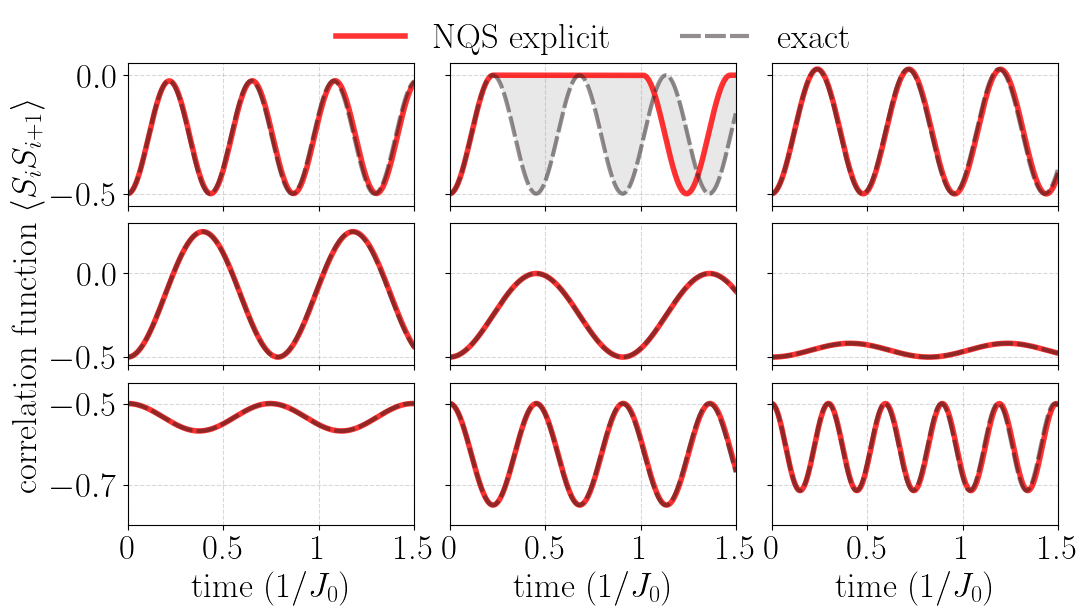

In [31]:
# plot settings
fig, axes = plt.subplots(3,3, figsize=(12, 6), sharex = True)
plt.subplots_adjust(hspace=0.125, wspace = 0.125)


# plot
for (i,ax) in enumerate(axes.flatten()):
    ax.plot(nqs[i].times, nqs[i].correlations[(0,2)], lw = 4, color = 'red', alpha = 0.8, label = 'NQS explicit')
    ax.plot(eds[i].times, eds[i].observables['correlations'][(0,2)], lw = 3, color = '#291F1E', ls = (0,(5,1)), alpha = 0.5, label = 'exact')
    ax.fill_between(eds[i].times, eds[i].observables['correlations'][(0,2)],nqs[i].correlations[(0,2)],
                    interpolate=True, color='#D4D2D5', alpha=0.5)

# x limits
for ax in axes.flatten():
    ax.set_xlim([0,1.5])

# y sharing
for row in axes:
    for ax in row[1:]:
        ax.sharey(row[0])
        ax.tick_params(labelleft=False)

# y limits
axes[0, 0].set_ylim(-0.55, 0.05)
axes[1, 0].set_ylim(-0.55, 0.3)
axes[2, 0].set_ylim(-0.8, -0.45)
axes[2, 0].set_yticks([-0.7, -0.5])

# grid lines
for ax in axes.flatten():
    ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.3)

# x ticks
for ax in axes.flatten():
    ax.set_xticks([0, 0.5, 1, 1.5])
    ax.set_xticklabels(["0", "0.5", "1", "1.5"])

# x labels
axes[2,0].set_xlabel("time $(1/J_0)$")
axes[2,1].set_xlabel("time $(1/J_0)$")
axes[2,2].set_xlabel("time $(1/J_0)$")

# y label
axes[1,0].set_ylabel(r"correlation function $\left< S_i S_{i+1} \right>$")

# legend
axes[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, frameon = False)

# saving
plt.savefig("nqs_deltas.svg", format="svg", bbox_inches = "tight")

# <span style='color: pink'> **Saving** </span>

In [ ]:
# times array, same for all data
times = eds[0].times

In [41]:
# set header
head = "time, ED spin correlation, NQS spin correlation"

# loop and save
for (i,d) in enumerate(deltas):
    filename = "data/correlation_delta_{:}.txt".format(d)
    np.savetxt(filename, np.c_[times, eds[i].observables['correlations'][(0,2)], nqs[i].correlations[(0,2)]], header = head, delimiter=", ")
